# step0: dependencies

In [1]:
import numpy as np
import tensorflow as tf
from collections import Counter
from random import shuffle
from gensim.models import KeyedVectors

import matplotlib.pyplot as plt
%matplotlib inline

import re
import os
import urllib.request
import zipfile
import lxml.etree

# step1: load data

In [2]:
# Download the dataset if it's not already there
if not os.path.isfile('ted_en-20160408.zip'):
    urllib.request.urlretrieve("https://wit3.fbk.eu/get.php?path=XML_releases/xml/ted_en-20160408.zip&filename=ted_en-20160408.zip", filename="ted_en-20160408.zip")

In [3]:
# extract both the texts and the labels from the xml file
with zipfile.ZipFile('ted_en-20160408.zip', 'r') as z:
    doc = lxml.etree.parse(z.open('ted_en-20160408.xml', 'r'))
texts = doc.xpath('//content/text()')
labels = doc.xpath('//head/keywords/text()')
del doc

In [4]:
print("There are {} input texts, each a long string with text and punctuation.".format(len(texts)))
print("")
print(texts[0][:100])

There are 2085 input texts, each a long string with text and punctuation.

Here are two reasons companies fail: they only do more of the same, or they only do what's new.
To m


In [5]:
print("There are {} labels in the form of keywords for each text.".format(len(labels)))
print("")
print(labels[0])

There are 2085 labels in the form of keywords for each text.

talks, business, creativity, curiosity, goal-setting, innovation, motivation, potential, success, work


# step2: preprocess and tokenize

In [6]:
# preprocess the texts: lowercase, replace punctuation with tokens, tokenize into words (split on whitespace)
#lowercase
input_texts = [input_text.lower() for input_text in texts]
#replace punctuation with punctuation tokens
input_texts = [re.sub(r'([^a-z0-9\s])', r' <\1_token> ', input_text) for input_text in input_texts]
#tokenize into words
input_texts = [input_text.split() for input_text in input_texts]
print(len(input_texts))
print(input_texts[0][:100])

2085
['here', 'are', 'two', 'reasons', 'companies', 'fail', '<:_token>', 'they', 'only', 'do', 'more', 'of', 'the', 'same', '<,_token>', 'or', 'they', 'only', 'do', 'what', "<'_token>", 's', 'new', '<._token>', 'to', 'me', 'the', 'real', '<,_token>', 'real', 'solution', 'to', 'quality', 'growth', 'is', 'figuring', 'out', 'the', 'balance', 'between', 'two', 'activities', '<:_token>', 'exploration', 'and', 'exploitation', '<._token>', 'both', 'are', 'necessary', '<,_token>', 'but', 'it', 'can', 'be', 'too', 'much', 'of', 'a', 'good', 'thing', '<._token>', 'consider', 'facit', '<._token>', 'i', "<'_token>", 'm', 'actually', 'old', 'enough', 'to', 'remember', 'them', '<._token>', 'facit', 'was', 'a', 'fantastic', 'company', '<._token>', 'they', 'were', 'born', 'deep', 'in', 'the', 'swedish', 'forest', '<,_token>', 'and', 'they', 'made', 'the', 'best', 'mechanical', 'calculators', 'in', 'the', 'world']


[  6.00000000e+00   8.10500000e+02   1.61500000e+03   2.41950000e+03
   3.22400000e+03   4.02850000e+03   4.83300000e+03   5.63750000e+03
   6.44200000e+03   7.24650000e+03   8.05100000e+03]


<Container object of 10 artists>

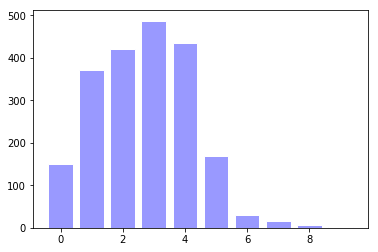

In [7]:
#histogram over input lengths
Y_plot, X_plot = np.histogram([len(text) for text in input_texts], bins=10)
print(X_plot)
X_plot = np.arange(10)
plt.bar(X_plot, +Y_plot, facecolor='#9999ff', edgecolor='white')

In [8]:
#remove all inputs that have less than 500 tokens in them
inputs = zip(input_texts, labels)
inputs = [text_and_labels for text_and_labels in inputs if len(text_and_labels[0]) > 500]
print("There are now only {} inputs left.".format(len(inputs)))
input_texts, labels = zip(*inputs)
input_texts, labels = list(input_texts), list(labels)

There are now only 2037 inputs left.


In [9]:
#get list of all words, and feed them into a Counter
all_words = [word for input_text in input_texts for word in input_text]
print("There are {} tokens in the dataset.".format(len(all_words)))
all_words_counter = Counter(all_words)

#remove some noise, take away the 100 most common and all words that only appear once
most_common_50 = [word for word, count in all_words_counter.most_common(100)]
only_once = [word for word, count in all_words_counter.most_common() if count == 1]
print("There are {} tokens that appear only once.".format(len(only_once)))

to_remove = set(only_once + most_common_50)
print("There are {} unique tokens to remove.".format(len(to_remove)))

input_texts = [[word for word in input_text if word not in to_remove] for input_text in input_texts]

new_all_words = [word for input_text in input_texts for word in input_text]
print("There are now only {} tokens in the dataset.".format(len(new_all_words)))

#input_texts[0]

There are 5353320 tokens in the dataset.
There are 18428 tokens that appear only once.
There are 18528 unique tokens to remove.
There are now only 2012408 tokens in the dataset.


In [10]:
# preprocess the labels: search for occurences of the keywords "technology", "entertainment" or "design" and build labels
label_lookup = ['ooo', 'Too', 'oEo', 'ooD', 'TEo', 'ToD', 'oED', 'TED']
for i in range(len(labels)):
    ted_labels = ['o', 'o', 'o']
    keyword_list = labels[i].split(', ')
    if 'technology' in keyword_list:
        ted_labels[0] = 'T'
    if 'entertainment' in keyword_list:
        ted_labels[1] = 'E'
    if 'design' in keyword_list:
        ted_labels[2] = 'D'
    labels[i] = ''.join(ted_labels)
    labels[i] = label_lookup.index(labels[i])
len(labels)
labels[:10]

[0, 0, 0, 3, 5, 0, 0, 0, 0, 5]

In [11]:
# transform labels to one-hot
labels_one_hot = np.zeros((len(labels), 8), dtype=int)            
labels_one_hot[range(len(labels)), labels] = 1
print(labels_one_hot[:10])

[[1 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0 0]
 [0 0 0 0 0 1 0 0]
 [1 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0]
 [0 0 0 0 0 1 0 0]]


In [12]:
# creating the unique vocabulary lookup
vocab_list = list(set([word for input_text in input_texts for word in input_text]))
word_to_index = {}
index_to_word = {}
for i, word in enumerate(vocab_list, 1):
    word_to_index[word] = i
    index_to_word[i] = word
input_indices_list = []
for input_text in input_texts:
    input_indices_list.append([word_to_index[word] for word in input_text])
#del vocab_list
#del input_texts
print(vocab_list[:10])
print(len(vocab_list))
print(len(word_to_index))
print(input_indices_list[0][:100])

['mended', 'scott', 'analyzes', 'negligible', 'titillate', 'egan', 'skewed', 'collaborative', 'yo', 'trouser']
36278
36278
[23671, 26313, 24371, 4147, 5524, 10293, 5524, 8643, 6031, 6031, 19774, 34453, 35035, 33545, 32118, 13759, 23671, 19335, 11769, 8408, 32962, 22091, 12183, 9610, 30199, 21966, 9080, 27460, 34211, 3345, 30967, 27460, 1385, 24827, 15380, 30077, 14724, 35266, 30330, 4290, 6854, 13579, 17178, 15853, 6905, 27460, 16360, 17029, 15547, 11638, 28544, 10230, 19657, 10293, 10933, 20058, 28481, 27719, 13873, 20628, 20628, 1648, 27460, 10312, 1302, 27460, 19130, 9607, 1620, 12386, 16360, 13579, 13172, 15853, 16545, 27168, 13579, 27460, 6905, 12183, 9610, 8408, 11769, 9372, 7330, 12183, 4107, 18360, 17706, 18039, 4353, 22076, 18899, 24827, 3121, 9907, 31905, 24827, 1690, 23127]


In [13]:
#load glove word vectors
glove = KeyedVectors.load_word2vec_format('glove.6B.50d.w2vformat.txt', binary=False)

In [14]:
#creating embeddings, checking for each word in the input texts whether it is part of 
#the glove corpus, if yes intialize that row in the embeddings with the glove value, if
#not initialize it uniformly between [-1.0, 1.0]
voc_len = len(word_to_index)
count = 0
embeddings = np.random.uniform(-.3, .3, size=(voc_len+1, 50))
for word, index in word_to_index.items():
    if word in glove.vocab:
        count += 1
        embeddings[index] = glove[word]
print("{}/{} words found in glove.".format(count, voc_len))

35111/36278 words found in glove.


In [15]:
# truncate every input text to a fixed length for now, taking only the first x tokens, zero pad if smaller
seq_length = 500
inputs_truncated = np.zeros((len(input_indices_list), seq_length), dtype=int)
for i, input_indices in enumerate(input_indices_list):
    if len(input_indices) >= seq_length:
        inputs_truncated[i, :seq_length] = np.array(input_indices)[:seq_length]
    else:
        inputs_truncated[i] = np.array(input_indices + ([0] * (seq_length-len(input_indices))))
print(inputs_truncated.shape)

(2037, 500)


In [16]:
#keep the class label distribution intact
inputs_combined = list(zip(inputs_truncated, labels_one_hot))
inputs_train, inputs_test, inputs_cv = [], [], []
for n in range(len(label_lookup)):
    inputs_of_curr_class = [inpu for inpu in inputs_combined if np.argmax(inpu[1]) == n]
    l = len(inputs_of_curr_class)
    split1 = round(0.8*l)
    split2 = round(0.9*l)
    inputs_train.extend(inputs_of_curr_class[:split1])
    inputs_cv.extend(inputs_of_curr_class[split1:split2])
    inputs_test.extend(inputs_of_curr_class[split2:])

shuffle(inputs_train)
shuffle(inputs_cv)
shuffle(inputs_test)
print((len(inputs_train), len(inputs_test), len(inputs_cv)))

(1630, 203, 204)


In [17]:
#now after shuffling we can unzip them again
train_x, train_y = list(zip(*inputs_train))
train_x, train_y = np.array([np.array(x) for x in train_x]), np.array(train_y)
test_x, test_y = list(zip(*inputs_test))
test_x, test_y = np.array([np.array(x) for x in test_x]), np.array(test_y)
cv_x, cv_y = list(zip(*inputs_cv))
cv_x, cv_y = np.array([np.array(x) for x in cv_x]), np.array(cv_y)
#train_y[:10]

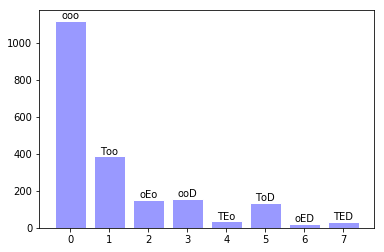

In [18]:
#plotting a histogram over the label distribution in the entire dataset
#as you can see 'ooo' is basically ~50% of the dataset, so an accuracy score
#of 50% could be reached by simply learning to predict 'ooo' all the time (not good)
Y_plot = np.histogram(labels, bins=8)[0]
X_plot = np.arange(8)
plt.bar(X_plot, +Y_plot, facecolor='#9999ff', edgecolor='white')
for x,y in zip(X_plot,Y_plot):
    plt.text(x, y+0.05, label_lookup[x], ha='center', va= 'bottom')

# step3: building the model

In [26]:
num_epochs = 20
batch_size = 200
learning_rate = 0.001
show_every_n_batches = 10

# size of hidden RNN state
rnn_size = 100
# length of input sequences
seq_length = 500
step_length = 10
num_steps = int(seq_length/step_length)
print(num_steps)
# length of word embeddings
embed_length = 50
#number of classes to classify between
n_classes = 8
#number of unique words in the vocabulary
n_words = len(vocab_list)
#number of RNN layers
rnn_layers = 1

50


In [27]:
# Create the graph object
graph = tf.Graph()

with graph.as_default():
    inputs_ph = tf.placeholder(tf.int32, [None, seq_length], name='inputs')
    labels_ph = tf.placeholder(tf.int32, [None, n_classes], name='labels')
    keep_prob = tf.placeholder(tf.float32, name='keep_prob')

In [28]:
with graph.as_default():
    #embedding = tf.Variable(tf.random_uniform((n_words, embed_length), -1, 1))
    embedding = tf.Variable(embeddings, "L")
    embed = tf.nn.embedding_lookup(embedding, inputs_ph)
    embed = tf.cast(embed, dtype=tf.float32)
    print(embed.get_shape())

(?, 500, 50)


In [29]:
with graph.as_default():
    # LSTM forward and backward cells
    lstm_fw = tf.contrib.rnn.BasicLSTMCell(rnn_size)
    
    # Add dropout to the cell
    drop = tf.contrib.rnn.DropoutWrapper(lstm_fw, output_keep_prob=keep_prob)
    
    # Stack up multiple LSTM layers, for deep learning
    cell = tf.contrib.rnn.MultiRNNCell([drop] * rnn_layers)
    
    # Getting an initial state of all zeros
    initial_state = cell.zero_state(batch_size, tf.float32)
    
    #print(out)
    # Computing the RNN outputs, truncated backprop style
    outputs, final_state = tf.nn.dynamic_rnn(cell, tf.cast(embed, dtype=tf.float32), initial_state=initial_state)
    print(outputs.get_shape())

(200, 500, 100)


In [30]:
with graph.as_default():
    #out
    #logits = tf.contrib.layers.fully_connected(inputs=outputs[:, -1], num_outputs=n_classes, activation_fn=None)
    logits = tf.contrib.layers.fully_connected(inputs=tf.reduce_mean(outputs, axis=1), num_outputs=n_classes, activation_fn=None)
    print(logits.get_shape())
    
    #loss
    #l2_cost = tf.nn.l2_loss(W1) + tf.nn.l2_loss(b1)
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=labels_ph))# + (0.01*l2_cost)
    optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost)
            
    #acc
    #predictions = tf.nn.softmax(logits)
    predictions = logits #no need to softmax here because we really only want the argmax
    correct_predictions = tf.equal(tf.argmax(predictions, axis=1), tf.argmax(labels_ph, axis=1))
    accuracy = tf.reduce_mean(tf.cast(correct_predictions, tf.float32))
    
    print(accuracy.get_shape())
    print(correct_predictions.get_shape())
    print(predictions.get_shape())

(200, 8)
()
(200,)
(200, 8)


In [31]:
def get_batches(x, y, batch_size=50):
    n_batches = len(x)//batch_size
    x, y = x[:n_batches*batch_size], y[:n_batches*batch_size]
    for i in range(0, len(x), batch_size):
        yield x[i:i+batch_size], y[i:i+batch_size]

# step4: training

In [33]:
with graph.as_default():
    saver = tf.train.Saver()

with tf.Session(graph=graph) as sess:
    sess.run(tf.global_variables_initializer())
    iteration = 1
    for e in range(num_epochs):
        state = sess.run(initial_state)
        print(train_y.shape)
        train_acc = []
        for i, (x, y) in enumerate(get_batches(train_x, train_y, batch_size), 1):
            feed = {inputs_ph: x,
                    labels_ph: y,
                    keep_prob: 0.5,
                    initial_state: state}
            loss, train_batch_acc, state, _ = sess.run([cost, accuracy, final_state, optimizer], feed_dict=feed)
            train_acc.append(train_batch_acc)
            
            if iteration%10==0:
                print("Epoch: {}/{}".format(e, num_epochs),
                      "Iteration: {}".format(iteration),
                      "Train loss: {:.3f}".format(loss))

            if iteration%10==0:
                cv_acc = []
                val_state = sess.run(cell.zero_state(batch_size, tf.float32))
                for x, y in get_batches(cv_x, cv_y, batch_size):
                    feed = {inputs_ph: x,
                            labels_ph: y,
                            keep_prob: 1.0,
                            initial_state: val_state}
                    pred, batch_acc, val_state = sess.run([predictions, accuracy, final_state], feed_dict=feed)
                    cv_acc.append(batch_acc)
                    #print(np.argmax(pred, axis=1))
                    #print(np.argmax(y, axis=1))
                print("Train acc: {:.3f}, Val acc: {:.3f}".format(np.mean(train_acc), np.mean(cv_acc)))
            iteration +=1
    saver.save(sess, "checkpoints/rnn_text_classification.ckpt")

(1630, 8)
(1630, 8)
Epoch: 1/20 Iteration: 10 Train loss: 1.437
Train acc: 0.510, Val acc: 0.550
(1630, 8)
Epoch: 2/20 Iteration: 20 Train loss: 1.329
Train acc: 0.539, Val acc: 0.550
(1630, 8)
Epoch: 3/20 Iteration: 30 Train loss: 1.419
Train acc: 0.538, Val acc: 0.550
(1630, 8)
Epoch: 4/20 Iteration: 40 Train loss: 1.141
Train acc: 0.561, Val acc: 0.560
(1630, 8)
(1630, 8)
Epoch: 6/20 Iteration: 50 Train loss: 1.098
Train acc: 0.560, Val acc: 0.575
(1630, 8)
Epoch: 7/20 Iteration: 60 Train loss: 1.140
Train acc: 0.565, Val acc: 0.570
(1630, 8)
Epoch: 8/20 Iteration: 70 Train loss: 1.183
Train acc: 0.595, Val acc: 0.575
(1630, 8)
Epoch: 9/20 Iteration: 80 Train loss: 0.893
Train acc: 0.627, Val acc: 0.615
(1630, 8)
(1630, 8)
Epoch: 11/20 Iteration: 90 Train loss: 0.912
Train acc: 0.632, Val acc: 0.620
(1630, 8)
Epoch: 12/20 Iteration: 100 Train loss: 0.964
Train acc: 0.650, Val acc: 0.635
(1630, 8)
Epoch: 13/20 Iteration: 110 Train loss: 0.988
Train acc: 0.659, Val acc: 0.610
(1630, 8

# step5: testing

Test accuracy: 0.625


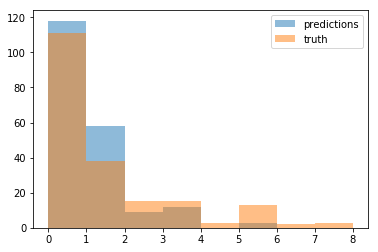

In [35]:
test_acc = []
test_preds_acc = []
true_labels_acc = []
with tf.Session(graph=graph) as sess:
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints/'))
    test_state = sess.run(cell.zero_state(batch_size, tf.float32))
    for x, y in get_batches(test_x, test_y, batch_size):
        feed = {inputs_ph: x,
                labels_ph: y,
                keep_prob: 1,
                initial_state: test_state}
        test_preds, batch_acc, test_state = sess.run([predictions, accuracy, final_state], feed_dict=feed)
        test_acc.append(batch_acc)
        test_preds_acc.extend(np.argmax(test_preds, axis=1))
        true_labels_acc.extend(np.argmax(y, axis=1))
        #print(np.argmax(test_preds, axis=1))
        #print(np.argmax(y, axis=1))
    print("Test accuracy: {:.3f}".format(np.mean(test_acc)))

bins = np.arange(9)
plt.hist(np.array(test_preds_acc), bins, alpha=0.5, label='predictions')
plt.hist(np.array(true_labels_acc), bins, alpha=0.5, label='truth')
plt.legend(loc='upper right')  

In [ ]:
print(input_texts[4][0:300])
print(labels[4])